# Brain Tumor Segmentation

## (Un)Healthy Brain Classification

In [1]:
import os
import cv2
import urllib
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations
import time
import argparse
from tqdm import tqdm
import warnings
import sklearn as sk
import itertools

# Pytorch libraries and subsidiaries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda as cuda
import torchvision as tv
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms as T
from torchsummary import summary # allows for keras-like summaries of models in pytorch
from torchvision.utils import make_grid

### Check CUDA Capability and Set Device

In [2]:
if cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on ' + cuda.get_device_name(device))
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on NVIDIA GeForce GTX 1070


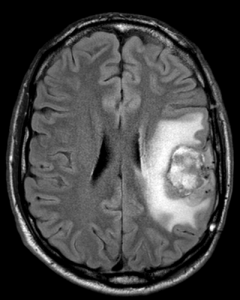

(300, 240, 3)

In [3]:
# Download an example image
path = ('brain-tumor-dataset/Brain Tumor/Cancer (1).png')

input_image = Image.open(path)

display(input_image)
cv2.imread(path).shape

### Create Pandas Dataframe of Images

In [4]:
tumor_dir = 'brain-tumor-dataset/Brain Tumor'
healthy_dir = 'brain-tumor-dataset/Healthy'
dirlist = [tumor_dir, healthy_dir]
classes = [1, 0] # 1 = tumor, 0 = no tumor
filepaths = []
labels = []
for d,c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

Fseries = pd.Series(filepaths, name='file_paths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries,Lseries], axis=1, names=['file_paths', 'labels'])
df = pd.DataFrame(np.array(df).reshape(7864,2), columns=['file_paths', 'labels'])
print(df['labels'].value_counts())

filepaths:  7864    labels:  7864
1    5277
0    2587
Name: labels, dtype: int64


### Dataset Splitting

In [5]:
train_df, test_df = train_test_split(df, train_size=0.90, random_state=0)
test_df, valid_df = train_test_split(test_df, train_size=0.5, random_state=0)

print('Training Set:')
print(train_df.labels.value_counts())
print('Validation Set:')
print(valid_df.labels.value_counts())
print('Test Set:')
print(test_df.labels.value_counts())

Training Set:
1    4753
0    2324
Name: labels, dtype: int64
Validation Set:
1    259
0    135
Name: labels, dtype: int64
Test Set:
1    265
0    128
Name: labels, dtype: int64


In [6]:
X_train = train_df.file_paths.values
y_train = train_df.labels.values
X_valid = valid_df.file_paths.values
y_valid = valid_df.labels.values
X_test = test_df.file_paths.values
y_test = test_df.labels.values

In [7]:
class BrainMRIDataset(Dataset):
    def __init__(self, X, y):
        self.X = X 
        self.y = y
    
    transform = T.Compose([
        # T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor()])

    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = image.convert('RGB')
        image = self.transform(image)
        image = np.transpose(image, (0, 2, 1))
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [8]:
train_data = BrainMRIDataset(X_train, y_train)
valid_data = BrainMRIDataset(X_valid, y_valid)
test_data = BrainMRIDataset(X_test, y_test)

trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
validloader = DataLoader(valid_data, batch_size=32, shuffle=False)
testloader = DataLoader(test_data, batch_size=1, shuffle=False)

### ResNet Model Definition

In [9]:
def resnet_model(pretrained, requires_grad):
    resnet_model = tv.models.resnet50(progress=True, pretrained=pretrained)
    # freeze hidden layers
    if requires_grad == False:
        for param in resnet_model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in resnet_model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
    return resnet_model
    
resnet_model = resnet_model(pretrained=True, requires_grad=False).to(device) # Frozen hidden layers model 
# print(model)

In [10]:
# optimizer
optimizer = optim.SGD(resnet_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
# loss function
criterion = nn.CrossEntropyLoss()

In [11]:
#validation function
def validate(model, valid_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_dataloader), total=int(len(valid_data)/valid_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(valid_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(valid_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [12]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct / len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [13]:
warnings.filterwarnings('ignore')

print('CUDA Enabled: ' + str(next(resnet_model.parameters()).is_cuda))

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

for epoch in range(50):
    print(f"Epoch {epoch + 1} of 50")
    train_epoch_loss, train_epoch_accuracy = fit(resnet_model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(resnet_model, validloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print(f"{(end-start) / 60:.3f} minutes")

  0%|          | 0/221 [00:00<?, ?it/s]

CUDA Enabled: True
Epoch 1 of 50
Training


222it [01:02,  3.57it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0113, Train Acc: 83.71
Validating


13it [00:03,  3.96it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0084, Val Acc: 92.39
Epoch 2 of 50
Training


222it [01:00,  3.66it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0086, Train Acc: 88.64
Validating


13it [00:03,  4.05it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0074, Val Acc: 93.91
Epoch 3 of 50
Training


222it [01:00,  3.66it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0079, Train Acc: 89.76
Validating


13it [00:03,  4.09it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0071, Val Acc: 94.16
Epoch 4 of 50
Training


222it [00:56,  3.96it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0076, Train Acc: 90.22
Validating


13it [00:03,  4.18it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0067, Val Acc: 93.91
Epoch 5 of 50
Training


222it [00:56,  3.94it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0068, Train Acc: 91.55
Validating


13it [00:03,  4.14it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0060, Val Acc: 95.18
Epoch 6 of 50
Training


222it [00:59,  3.74it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0066, Train Acc: 91.96
Validating


13it [00:02,  4.51it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0056, Val Acc: 94.92
Epoch 7 of 50
Training


222it [00:51,  4.27it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0063, Train Acc: 92.38
Validating


13it [00:02,  4.78it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0057, Val Acc: 95.18
Epoch 8 of 50
Training


222it [00:51,  4.33it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0063, Train Acc: 92.06
Validating


13it [00:02,  4.72it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0059, Val Acc: 94.42
Epoch 9 of 50
Training


222it [00:50,  4.37it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0063, Train Acc: 91.71
Validating


13it [00:02,  4.80it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0057, Val Acc: 93.40
Epoch 10 of 50
Training


222it [00:50,  4.39it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0061, Train Acc: 92.33
Validating


13it [00:02,  4.74it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0051, Val Acc: 95.43
Epoch 11 of 50
Training


222it [00:50,  4.37it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0058, Train Acc: 93.01
Validating


13it [00:02,  4.83it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0050, Val Acc: 95.18
Epoch 12 of 50
Training


222it [00:50,  4.37it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0057, Train Acc: 92.69
Validating


13it [00:02,  4.78it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0053, Val Acc: 95.18
Epoch 13 of 50
Training


222it [00:51,  4.35it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0057, Train Acc: 92.69
Validating


13it [00:02,  4.65it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0047, Val Acc: 94.92
Epoch 14 of 50
Training


222it [00:51,  4.33it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0053, Train Acc: 93.75
Validating


13it [00:02,  4.74it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 95.18
Epoch 15 of 50
Training


222it [00:50,  4.39it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0055, Train Acc: 93.19
Validating


13it [00:02,  4.86it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0045, Val Acc: 95.94
Epoch 16 of 50
Training


222it [00:50,  4.37it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0053, Train Acc: 93.56
Validating


13it [00:02,  4.83it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0055, Val Acc: 94.16
Epoch 17 of 50
Training


222it [00:50,  4.38it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0051, Train Acc: 93.58
Validating


13it [00:02,  4.70it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0042, Val Acc: 95.43
Epoch 18 of 50
Training


222it [00:51,  4.33it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0053, Train Acc: 93.64
Validating


13it [00:02,  4.68it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0040, Val Acc: 95.43
Epoch 19 of 50
Training


222it [00:50,  4.37it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0052, Train Acc: 93.92
Validating


13it [00:02,  4.75it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0042, Val Acc: 95.18
Epoch 20 of 50
Training


222it [00:50,  4.41it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0049, Train Acc: 94.04
Validating


13it [00:02,  4.65it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0040, Val Acc: 95.69
Epoch 21 of 50
Training


222it [00:50,  4.39it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0050, Train Acc: 93.92
Validating


13it [00:02,  4.90it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0040, Val Acc: 97.72
Epoch 22 of 50
Training


222it [00:50,  4.36it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0051, Train Acc: 93.97
Validating


13it [00:02,  4.76it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0039, Val Acc: 97.21
Epoch 23 of 50
Training


222it [00:50,  4.37it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0049, Train Acc: 93.91
Validating


13it [00:02,  4.71it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0040, Val Acc: 96.19
Epoch 24 of 50
Training


222it [00:50,  4.40it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0050, Train Acc: 93.88
Validating


13it [00:02,  4.73it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0039, Val Acc: 96.45
Epoch 25 of 50
Training


222it [00:50,  4.35it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0048, Train Acc: 94.42
Validating


13it [00:02,  4.74it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0040, Val Acc: 96.70
Epoch 26 of 50
Training


222it [00:51,  4.35it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0047, Train Acc: 94.42
Validating


13it [00:02,  4.69it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0038, Val Acc: 95.94
Epoch 27 of 50
Training


222it [00:50,  4.36it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0046, Train Acc: 94.46
Validating


13it [00:02,  4.81it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0036, Val Acc: 96.70
Epoch 28 of 50
Training


222it [00:50,  4.35it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0048, Train Acc: 94.02
Validating


13it [00:02,  4.76it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0047, Val Acc: 94.67
Epoch 29 of 50
Training


222it [00:50,  4.37it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0048, Train Acc: 94.15
Validating


13it [00:02,  4.83it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0038, Val Acc: 97.21
Epoch 30 of 50
Training


222it [00:50,  4.38it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0046, Train Acc: 94.29
Validating


13it [00:02,  4.54it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0035, Val Acc: 95.94
Epoch 31 of 50
Training


222it [00:50,  4.36it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 94.69
Validating


13it [00:02,  4.69it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0034, Val Acc: 97.97
Epoch 32 of 50
Training


222it [00:50,  4.41it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 94.73
Validating


13it [00:02,  4.89it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0034, Val Acc: 97.21
Epoch 33 of 50
Training


222it [00:51,  4.29it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0047, Train Acc: 94.45
Validating


13it [00:02,  4.80it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0037, Val Acc: 95.43
Epoch 34 of 50
Training


222it [00:54,  4.05it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0048, Train Acc: 94.11
Validating


13it [00:03,  3.46it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0036, Val Acc: 96.19
Epoch 35 of 50
Training


222it [00:59,  3.73it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0042, Train Acc: 95.11
Validating


13it [00:03,  4.29it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0032, Val Acc: 97.72
Epoch 36 of 50
Training


222it [00:54,  4.09it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 94.73
Validating


13it [00:03,  4.21it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0045, Val Acc: 94.16
Epoch 37 of 50
Training


222it [00:55,  4.03it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 94.74
Validating


13it [00:02,  4.49it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0034, Val Acc: 96.70
Epoch 38 of 50
Training


222it [00:51,  4.33it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0043, Train Acc: 94.67
Validating


13it [00:02,  4.55it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0034, Val Acc: 97.72
Epoch 39 of 50
Training


222it [00:53,  4.12it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 94.59
Validating


13it [00:03,  4.03it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0032, Val Acc: 96.45
Epoch 40 of 50
Training


222it [01:12,  3.06it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0040, Train Acc: 95.29
Validating


13it [00:03,  4.31it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0031, Val Acc: 97.97
Epoch 41 of 50
Training


222it [00:56,  3.96it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 94.74
Validating


13it [00:03,  3.79it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0031, Val Acc: 96.95
Epoch 42 of 50
Training


222it [00:57,  3.83it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0041, Train Acc: 95.22
Validating


13it [00:02,  4.36it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0031, Val Acc: 97.21
Epoch 43 of 50
Training


222it [01:00,  3.67it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0040, Train Acc: 95.11
Validating


13it [00:03,  4.11it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0032, Val Acc: 96.95
Epoch 44 of 50
Training


222it [00:55,  4.02it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0040, Train Acc: 95.14
Validating


13it [00:03,  4.33it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0034, Val Acc: 96.19
Epoch 45 of 50
Training


222it [00:58,  3.78it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0041, Train Acc: 95.34
Validating


13it [00:02,  4.47it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0035, Val Acc: 95.43
Epoch 46 of 50
Training


222it [00:57,  3.86it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0040, Train Acc: 95.28
Validating


13it [00:03,  3.89it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0031, Val Acc: 96.45
Epoch 47 of 50
Training


222it [00:57,  3.83it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0040, Train Acc: 95.14
Validating


13it [00:03,  4.29it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0032, Val Acc: 96.19
Epoch 48 of 50
Training


222it [00:54,  4.06it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0039, Train Acc: 95.25
Validating


13it [00:02,  4.46it/s]
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0029, Val Acc: 97.72
Epoch 49 of 50
Training


222it [00:54,  4.11it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0041, Train Acc: 95.01
Validating


13it [00:02,  4.54it/s]                        
  0%|          | 0/221 [00:00<?, ?it/s]

Val Loss: 0.0033, Val Acc: 97.46
Epoch 50 of 50
Training


222it [00:53,  4.12it/s]                         
  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0039, Train Acc: 95.48
Validating


13it [00:02,  4.47it/s]                        

Val Loss: 0.0030, Val Acc: 96.70
47.388 minutes


In [14]:
PATH = './resnet_brain.pth'
torch.save(resnet_model.state_dict(), PATH)

In [15]:
# Testing
correct = 0
total = 0
y_pred = torch.Tensor([]).cuda()
X_wrong = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = resnet_model(images) # feed images into resnet and get predictions
        y_pred = torch.cat((y_pred, outputs), dim=0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if(predicted != labels):
            X_wrong.append(images.cpu())

y_pred = np.uint8(np.argmax(y_pred.cpu(), axis=1))
y_test = np.uint8(y_test)
print('Test Accuracy: %d %%' % (100 * correct / total))

Test Accuracy: 95 %


In [16]:
conf_matrix = sk.metrics.confusion_matrix(y_test, y_pred)

In [17]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[125   3]
 [ 14 251]]


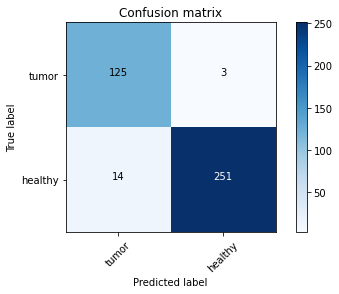

In [18]:
plot_confusion_matrix(conf_matrix, ['tumor', 'healthy'])


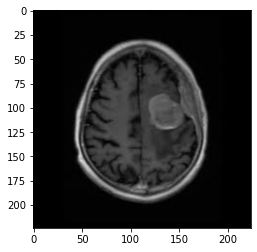

In [26]:
fig = plt.figure()
plt.imshow(X_wrong[0].permute(3, 2, 0, 1).squeeze())

### UNet Model Definition

In [20]:
def unet_model(pretrained, requires_grad):
    unet_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=pretrained)
    
    # freeze hidden layers
    if requires_grad == False:
        for param in unet_model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in unet_model.parameters():
            param.requires_grad = True
    return unet_model

unet_model = unet_model(pretrained=True, requires_grad=False).to(device) # Frozen hidden layers model 
# print(model)

Using cache found in C:\Users\Chill/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
